# Severity Modelling

This covers the second part of the modelling. The target variable is the loss.

## 001: Create the dataset and split dataset

In [ ]:
from src.model.dataset import Dataset

insurance_initiation_variables_path = "../data/input/exp/Insurance_Initiation_Variables.csv"
claims_variables_path = "../data/input/exp/sample_type_claim.csv"

claim_grouping_columns = ['ID', 'Cost_claims_year']
claim_aggregation_column = 'Cost_claims_by_type'
merging_columns = ['ID', 'Cost_claims_year']

dataset = (Dataset(data_path=insurance_initiation_variables_path,
                   claims_path=claims_variables_path)
           .group_claims(grouping_columns=claim_grouping_columns, aggregation_column=claim_aggregation_column)
           .create_dataset(merge_columns=merging_columns)
           )
trainset, testset = dataset.split_dataset(test_ratio=0.2, to_shuffle=False)

## 002: Engineer relevant features

In [4]:
from model.feature import main as feature_main

features_trainset = feature_main(trainset)
features_testset = feature_main(testset)

## 003: Severity modelling

The response variable is the number of claims dubbed `Cost_claims_year` in the dataset. The first step would be to understand the distribution of the response variable

Average loss distribution: 149.84895492871016


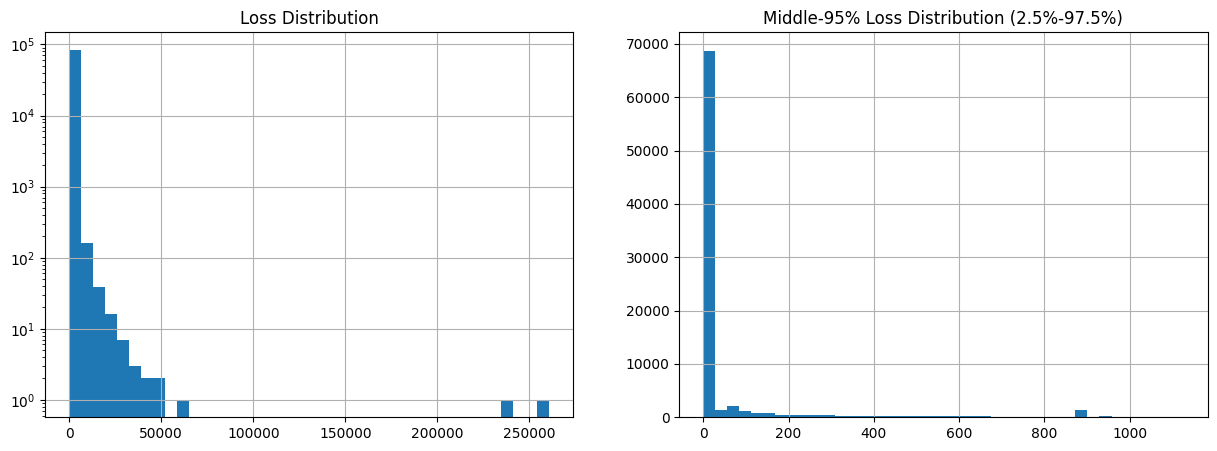

In [42]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))
ax0.set_title('Loss Distribution')
_ = features_trainset['Cost_claims_year'].hist(bins=40, log=True, ax=ax0)


p2_5, p97_5 = np.percentile(features_trainset['Cost_claims_year'], [2.5, 97.5])
middle_95 = features_trainset['Cost_claims_year'][(features_trainset['Cost_claims_year'] >= p2_5) &
                                                   (features_trainset['Cost_claims_year'] <= p97_5)]
ax1.set_title('Middle-95% Loss Distribution (2.5%-97.5%)')
_ = middle_95.hist(bins=40, log=False, ax=ax1)

print(
    "Average loss distribution: {}".format(
        np.average(features_trainset['Cost_claims_year'])
    )
)

In [8]:
training_variables = ['Car_age_years', 'Type_risk', 'Area', 'Value_vehicle', 'Distribution_channel',
                      'Cylinder_capacity']
target = ['Cost_claims_year']

In [19]:
from sklearn.metrics import mean_absolute_error,mean_poisson_deviance,mean_squared_error

def model_evaluation_metrics(estimator, df_test, target_variable=target, training_variables=training_variables):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test[training_variables])

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test[target], y_pred,
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test[target], y_pred
        )
    )

In [32]:
from sklearn.linear_model import GammaRegressor

train_mask = features_trainset['Cost_claims_year']>0
updated_features_trainset = features_trainset[train_mask]
test_mask = features_testset['Cost_claims_year']>0
updated_features_testset = features_testset[test_mask]

gamma_regressor = GammaRegressor(max_iter=300)
baseline_model =  gamma_regressor.fit(updated_features_trainset[training_variables], updated_features_trainset[target].values.ravel())
print("Baseline model using gamma regressor")
model_evaluation_metrics(estimator=baseline_model, df_test=features_testset, target_variable=target, training_variables=training_variables)


Baseline model using gamma regressor
MSE: 2307583.679
MAE: 806.024


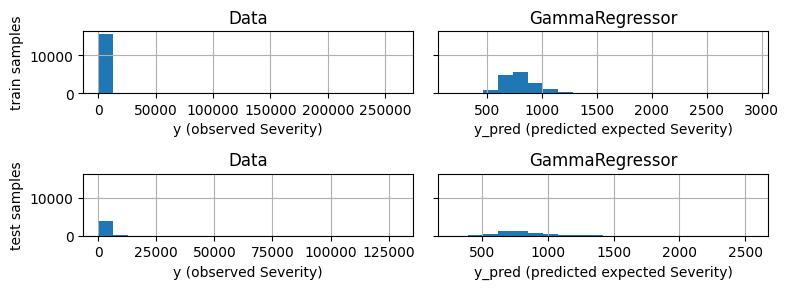

In [48]:
import pandas as pd
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 3), sharey=True)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [updated_features_trainset, updated_features_testset]):
    df["Cost_claims_year"].hist(bins=n_bins, ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_xlabel("y (observed Severity)")
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([baseline_model ]):
        y_pred = model.predict(df[training_variables])

        pd.Series(y_pred).hist(
            bins=n_bins, ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set_title(model.__class__.__name__)
        axes[row_idx, idx + 1].set_xlabel("y_pred (predicted expected Severity)")
plt.tight_layout()

## 004: Severity Modelling Evaluation